**IMPORTANT:** You should run this using a GPU! In Colab, go to the "runtime" menu, choose "change runtime type", and select "GPU" from the hardware accelerator dropdown menu. Otherwise, this might take much longer. 

There are **5** places you need to write code in this notebook, for questions **1**, **2a** and **2b**, **3a** and **3b**. All parts are with 10 points, for a total of 50 points.

To turn in this homework: download as .ipynb (File -> download as .ipynb). Make the filename YOURNAME_PA2.ipynb and send via email attachment to opt4mlclass+fall2023@gmail.com. with your name and PA2 in the subject line.

Be aware: this assignment may require up to 2 hours of computation even when everything is implemented correctly.

Please read the comments and explanation code carefully. In particular, you may want to study the provided implementation of SGD to get an idea of how the pytorch optimizer class works.

In [1]:
# Clone attention modeling and training code needed for question 3
# !git clone https://github.com/optmlclass/PA2_fall2023.git PA2

# get harry potter data (also for question 3)
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
!wget "https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%201%20-%20Sorcerer's%20Stone.txt"
!wget "https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%202%20-%20The%20Chamber%20Of%20Secrets.txt"
!wget "https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%203%20-%20Prisoner%20of%20Azkaban.txt"
!wget "https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%204%20-%20The%20Goblet%20of%20Fire.txt"

--2023-11-04 01:00:58--  https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%201%20-%20Sorcerer's%20Stone.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 439742 (429K) [text/plain]
Saving to: ‘J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt’

J. K. Rowling - Har 100%[===================>] 429.44K  --.-KB/s    in 0.01s   

2023-11-04 01:00:58 (34.4 MB/s) - ‘J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt’ saved [439742/439742]

--2023-11-04 01:00:59--  https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%202%20-%20The%20Chamber%20Of%20Secrets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.

In [3]:
import torch, torchvision
import torchvision.transforms as transforms
from torch.optim import Optimizer
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections.abc import Iterable

# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

# make deterministic
# from PA2.sequenceutils import set_seed
from sequenceutils import set_seed
set_seed(42)

# imports for attention model
# more imports
# from PA2.attentionmodel import GPT, GPTConfig
# from PA2.sequenceutils import sample, CharDataset
# from PA2.attentiontrainer import Trainer, TrainerConfig
from attentiontrainer import Trainer, TrainerConfig
from attentionmodel import GPT, GPTConfig
from sequenceutils import sample, CharDataset

In [4]:
# Basic SGD implementation for reference.
# for base class, see https://github.com/pytorch/pytorch/blob/master/torch/optim/optimizer.py
# for official pytorch SGD implementation, see https://github.com/pytorch/pytorch/blob/master/torch/optim/sgd.py

class SGD(Optimizer):
  def __init__(self, params, lr=1.0):
    super(SGD, self).__init__(params, {'lr': lr})

    # The params argument can be a list of pytorch variables, or
    # a list of dicts. If it is a list of dicts, each dict should have 
    # a key 'params' that is a list of pytorch variables,
    # and optionally another key 'lr' that specifies the learning rate
    # for those variables. If 'lr' is not provided, the default value
    # is the single value provided as an argument after params to this
    # constructor.
    # If params is just a list of pytorch variables, it is the same
    # as if params were actually a list containing a single dictionary
    # whose 'params' key value is the list of variables.
    # See examples in following code blocks for use of params.

    # Set up an iteration counter.
    # self.state[p] is a python dict for each parameter p
    # that can be used to store various state useful in the optimization
    # algorithm. In this case, we simply store the iteration count, although
    # it is not used in this simple algorithm.
    for group in self.param_groups:
      for p in group['params']:
        state = self.state[p]
        state['step'] = 0


  @torch.no_grad()
  def step(self, closure=None):
    '''
    closure is a function that computes the loss and returns it.
    '''
    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()

    for group in self.param_groups:
      #group: dict, {"params": [p1, p2, ...], "lr": 0.1, ...}
      lr = group['lr']

      # it is common practice to call the model parameters p in code.
      # in class we follow more closely analytical conventions, in which the
      # parameters are often called w for weights.
      for p in group['params']:
        #group['params']: [p1, p2, ...]
        if p.grad is None:
          continue
        
        # Update the iteration counter (again, this is not actually used in this algorithm)
        state = self.state[p]
        step = state['step']
        step += 1
        
        # Perform the SGD update. p.grad holds the gradient of the loss
        # with respect to p.
        p -= lr * p.grad

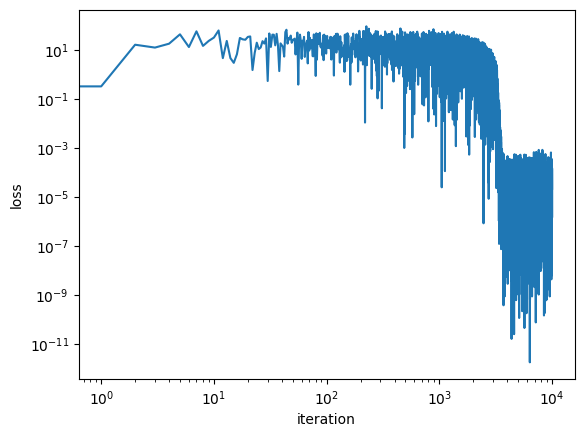

In [5]:
#Simple linear regression problem
dimension = 10
num_iter = 10000

mean = torch.zeros(dimension)
std = torch.ones(dimension)

def loss_func(w_hat, b_hat, w_true, b_true):
  # simple linear regression problem, although
  # slightly non-standard loss. See pytorch docs
  # for description of loss function.

  # features
  x = torch.normal(mean, std) #generate a guassian vector with mean and std 

  # true label is a linear function of features plus noise.
  noise = np.random.normal(0.0, 0.01)
  y_true = torch.dot(x, w_true) + b_true + noise

  y_hat = torch.dot(x, w_hat) + b_hat

  loss = torch.nn.SmoothL1Loss()
  return loss(y_hat, y_true)


# Set "true" parameter value to be a random normal vector with covariance 10*I
w_true = 10*torch.normal(mean, std)

# make true bias term quite large so that it is better
# to have a high learning rate for the bias. This makes
# it advantageous to use the params as a dict in the 
# following cell.
b_true = torch.normal(torch.zeros(1), torch.ones(1))


# declare variables that will actually be trained.
# "requires_grad" tells pytorch that it may have to compute
# gradients with respect to these variables so that it initialize the 
# relevant autograd data structures.
w = torch.zeros(dimension, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

optimizer = SGD([w, b], 0.010)

losses = []

for t in range(num_iter):

  # "zero_grad" resets all variable.grad values to 0 and resets all
  # intermediate data that might have been saved for a backwards pass.
  # This is useful when variables need to be reused for many backward passes.
  # Note that your PA1 autograd implementation did not need to have this
  # functionality because the SGD you implemented just created  new
  # variables every iteration.
  optimizer.zero_grad()

  # Compute the loss function - this is the forward pass
  loss = loss_func(w, b, w_true, b_true)

  # loss.backward has essentially the same functionality as the .backward
  # function you implemented in PA1.
  loss.backward()

  optimizer.step()

  losses.append(loss.item())

plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.xscale('log')
plt.yscale('log')
plt.show()

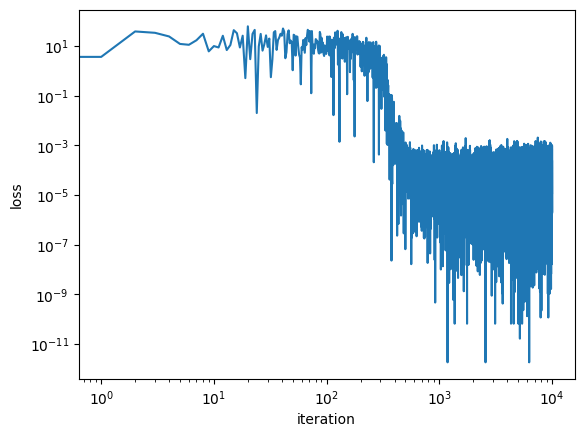

In [7]:

w = torch.zeros(dimension, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
param_groups = [{'params': [w], 'lr': 0.1}, {'params': [b], 'lr': 0.01}]
optimizer = SGD(param_groups, 0.10)

losses = []
for t in range(num_iter):
  optimizer.zero_grad()
  loss = loss_func(w, b, w_true, b_true)
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.xscale('log')
plt.yscale('log')
plt.show()

Remarks

1. WHat are these "`p`" values representing?

In class, we frequently consider a single parameter $w$ to describe the model we are training, so that $w$ would represent all the weights in a neural network for example. However, in practice usually models are specified in a more modular manner. For example, we could have a linear model with a bias as:
$$
\hat y = \langle A, x\rangle + B
$$
where $A\in \mathbb{R}^d$ is a weight vector and $B\in\mathbb{R}$ is a bias. For theoretical analyses, we might consider this model as parametrized by a single vector $w\in \mathbb{R}^{d+1}$, but when programming it is far simpler to have separate variables for $A$ and $B$. Just as in your previous programming assignment, the `A.grad` and `B.grad` variables will then be populated with  the partial derivatives of the overall loss with respect to $A$ and $B$. Thus, to implement a gradient based optimizer, we need to loop over all variables that were involved in specifying the model. `p` is the variable used to step through this loop, so in the linear model with bias example, `p` would take on both `A` and `B` as values.

2. What does `@torch.no_grad` do? 

This tells pytorch not to record gradient operations for anything that happens inside the function, so it will not be able to compute derivatives of these operations. However, this is important to enable because some operations (like performing an update) inherently should not be differentiated, and pytorch will thrown an error if you do not explicitly tell it that you do not want to differentiate through this operation.

3. Why do we need `torch.enable_grad` when using the closure?

Computing the closure (closure is essentially a fancy name for "function") is an alternative to providing the gradient to the optimization step. Instead, the loss $\ell(w_t, z_t)$ is computed by the closure. However, the closure might need to compute some derivatives, so we turn on `torch.enable_grad`.

## PART 1: Per-Variable AdaGrad

#Question 1

1. Fill out the class below to implement a version of SGD that sets the "adaptive" learning rate on a per-pytorch variable basis:
$$
\eta_t[p] = \frac{lr}{\sqrt{G_t[p]}}
$$
$lr$ (for "learning rate") is provided as input to the algorithm, $t$ is the current iteration count, and
$$
G_t[p] = \sum_{i=1}^t \|\nabla \ell(w_i, z_i)[p]\|^2
$$
where here $p$ indicates a pytorch variable object (which could be a high-dimensional vector), and $\nabla \ell(w_t, z_t)[p]$ indicates the partial derivative with respect to $p$ (i.e. the coordinates of the gradient corresponding to $p$).
If you are familiar with the AdaGrad update, note that this is NOT the same because AdaGrad uses a *per-coordinate* learning rate, while we use a *per-variable* learning rate. For very large models in which memory is at a premium, this kind of change can reduce the memory required by the optimizer while still preserving some of the adaptive properties of AdaGrad.

Read the `__init__` method carefully as it has changed slightly from the original `SGD` class above.



In [8]:
class SGD_adaptive(Optimizer):
  def __init__(self, params, lr=1.0):
    super(SGD_adaptive, self).__init__(params, {'lr': lr})

  ####### YOUR CODE HERE (IF NEEDED) #####


  @torch.no_grad()
  def step(self, closure=None):
    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()

        
    ####### YOUR CODE HERE ########
    for group in self.param_groups:
      lr = group['lr']
      eps = group.get('eps', 1e-10)
      for p in group['params']:
        if p.grad is None:
          continue
        state = self.state[p]
        if len(state) == 0:
          #initialize state for each parameter
          state['step'] = 0
          state['grad_sum_sq'] = torch.zeros_like(p.data) # running sum of the squares of the gradients for each parameter
         
        grad = p.grad.data
        state['step'] += 1
        # add_ : inplace addition, replace the original value without creating a new tensor
        state['grad_sum_sq'].add_(grad.pow(2))
        
        std = state['grad_sum_sq'].sqrt() + eps
        
        adaptive_lr = lr / std
        p.data.add_(-adaptive_lr*grad) # p.data = p.data - adaptive_lr * grad / std, but withou creating a new tensor
        
        


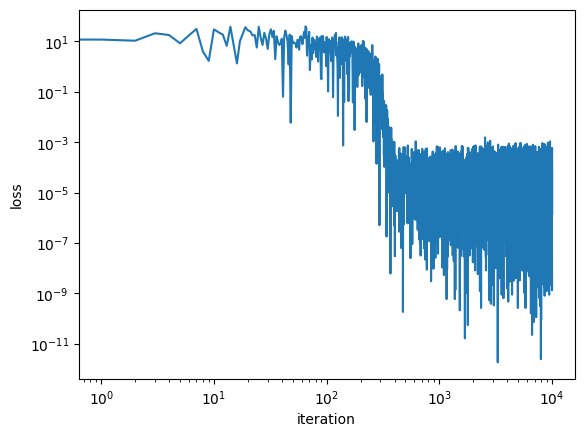

In [9]:
w = torch.zeros(dimension, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
optimizer = SGD_adaptive([w, b], 1.0)
losses = []
for t in range(num_iter):
  optimizer.zero_grad()
  loss = loss_func(w, b, w_true, b_true)
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.xscale('log')
plt.yscale('log')
plt.show()

See https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py for some similar example of how to set up the process below, from which much of this was copied.

In [10]:
## These commands create two pytorch "DataLoader" objects, one for training
# data and one for testing data.
# A DataLoader object is essentially a list of training/testing examples with
# some extra code attached by pytorch that can send the data to GPUs.

# The following three commands produce a torchvision dataset object for both
# training and testing data on the CIFAR10 dataset, which is a dataset of images.
# these objects are like lists of vectors (the "transform" specifies a function
# that converts images to vectors).
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
CIFAR_train = torchvision.datasets.CIFAR10(root='CIFAR10/', train=True, download=True, transform=transform)
CIFAR_test = torchvision.datasets.CIFAR10(root='CIFAR10/', train=False, transform=transform)


# The next two lines produce the actual DataLoaders. The batch_size argument sets
# the batch size, so that the DataLoader will appear like a list [a,b,c...] where
# each entry of the list is a batch of batch_size examples. 
# Setting shuffle=True makes it so that when you start iterating over the examples
# in the DataLoader, it will first shuffle the order of the list.
trainloader = torch.utils.data.DataLoader(CIFAR_train, batch_size=16,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(CIFAR_test, batch_size=256,
                                          shuffle=True)

Files already downloaded and verified


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)


Using the GPU!
cuda:0


In [12]:
## Please read the function signatures and doc string for "train_resnet" function.
# You do not need to otherwise understand how it works to do this homework. ##

def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train_resnet(optimizer, train_loader, device, lrs, wd=0.01, model=None):
  '''
  Trains a resnet model on CIFAR10 data.

  args:
    optimizer: optimizer class that will be instantiated inside this function.
    train_loader: pytorch DataLoader object that provides the training examples.
    device: pytorch device to use (e.g. a GPU).
    lrs: list of learning rates. The length of the list is the number of epochs
      to train for. At the start of the ith epoch, the 'lr' parameter of the
      optimizer will be set to lrs[i].
    wd: l2 regularization constant.
    model: can provide a preset pytorch model to train from a checkpoint. If 
      None, will instantiate a fresh resnet18 model.

  returns:
    the trained pytorch model object.
  '''

  if model is None:
    model = torchvision.models.resnet18(pretrained=False)
  model.to(device)


  # define \ell as the cross-entropy function.
  # this function as implemented in pytorch actually combines both the softmax
  # and the cross entropy function into one. As a result, it is
  # is non-negative, smooth, Lipschitz, and convex in its argument, which
  # are the predicted scores for various classes output by some model.
  # Note that this does NOT necessarily imply that it has these properties
  # with respect to the parameters of the model.
  cross_entropy_loss = torch.nn.CrossEntropyLoss()

  optimizer = SGD_adaptive(model.parameters(), lrs[0])

  num_epochs = len(lrs)

  average_loss = 0.0

  for epoch, lr in enumerate(lrs):#range(num_epochs):
    # iterate over training set. One full pass over the training set is called
    # an "epoch".
    # i is index of example, data is the example (e.g. z_i).
    # because shuffle=True when defining the trainloader,
    # the training set is shuffled after every complete pass.

    adjust_learning_rate(optimizer, lr)

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    for it, data in pbar:
      # unpack the example data: inputs is a batch of images,
      # labels is a batch of labels.
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # pytorch will keep details from old gradients around in case you are going
      # to differentiate something else. We therefore need to delete this old
      # data before computing the loss so that we only have the gradient
      # for this iteration.
      optimizer.zero_grad()

      predicted_labels = model.forward(inputs)
      loss = cross_entropy_loss(predicted_labels, labels)

      weight_decay = wd * 0.5 * sum([torch.linalg.norm(p)**2 for p in model.parameters()])

      regularized_loss = loss + weight_decay

      # tell pytorch to compute some gradients
      regularized_loss.backward()

      optimizer.step()

      

      average_loss += (loss.item() - average_loss)/(it+1)

      pbar.set_description(f"epoch {epoch + 1} iter {it + 1}: train loss {average_loss:.5f}.")

    average_loss = 0.0

  print('\nFinished Training')

  return model


In [13]:
## Train the model for 3 epochs using a learning rate of 0.1 in each epoch.
## If this fails, you probably have a significant bug in your SGD code.
## Each epoch should take < 5 minutes, for a total of at most 15 minutes.
trained_model = train_resnet(SGD_adaptive, trainloader, device, lrs=[0.1, 0.1, 0.1])

/home/ubuntu/miniconda3/envs/ipynb/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/ipynb/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
epoch 3 iter 3125: train loss 1.56709.: 100%|██████████| 3125/3125 [01:29<00:00, 34.88it/s]


Finished Training


In [14]:
# These functions take input a trained model and return either the train or
# test accuracy.
def get_train_accuracy(trained_model):
  correct = 0
  total = 0
  with torch.no_grad():
    trainloader = torch.utils.data.DataLoader(CIFAR_train, batch_size=256, num_workers=2)
    for data in trainloader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = trained_model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return 100 * correct / total

def get_test_accuracy(trained_model):
  correct = 0
  total = 0
  with torch.no_grad():
    testloader = torch.utils.data.DataLoader(CIFAR_test, batch_size=256, num_workers=2)
    for data in testloader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = trained_model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return 100 * correct / total

In [15]:
## Print the test accuracy. The test accuracy should be ~50% because the learning
## rate of 0.1 used earlier is not a good learning rate.
test_accuracy = get_test_accuracy(trained_model)
print("test accuracy percentage: ", test_accuracy)

test accuracy percentage:  47.23


#Question 2a

Write a function that returns a DataLoader object (like the `trainloader` variable) for the training set that uses the provided argument as a batch size.

In [16]:
import torch
from torchvision import datasets, transforms
def get_trainloader(batch_size):
  ### YOUR CODE HERE ###
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) #convert to [-1,1], channels: (R,G,B)
    ])

    # Download and load the training data
    trainset = torchvision.datasets.CIFAR10(root='CIFAR10/', train=True, download=True, transform=transform)

    # Create the DataLoader
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    return trainloader


#Question 2b

Now, for each batch size in `[16, 64, 256]`, populate the dictionary `trained_models` with a model trained using that batch size for three epochs using `train_resnet`, the `SGD_adaptive` algorithm. Then run the next cell, which will print the train and test accuracies. **Tune the learning rate schedules to get the best test performance at batch size 16. You should get close to or better than 70%.**

In [17]:
## With batch size 16, each epoch should take < 5 minutes (for a total of 15 minutes).
## With batch size 64, < 2 minutes.
## With batch size 256 < 1 minute.
batch_size_list = [16, 64, 256]
trained_models = {16: None, 64: None, 256: None}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for batch_size in batch_size_list:
  lrs =[0.01,0.005,0.001]   #[first epoch lr, second epoch lr, third epoch lr]
  ### YOUR CODE HERE ###
  trainloader = get_trainloader(batch_size)
  model = train_resnet(SGD_adaptive, trainloader, device, lrs, wd=0.01, model=None)
  trained_models[batch_size] = model


Files already downloaded and verified


/home/ubuntu/miniconda3/envs/ipynb/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/ipynb/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
epoch 3 iter 3125: train loss 0.84928.: 100%|██████████| 3125/3125 [01:30<00:00, 34.51it/s]



Finished Training
Files already downloaded and verified


epoch 3 iter 782: train loss 0.72243.: 100%|██████████| 782/782 [00:32<00:00, 24.44it/s]



Finished Training
Files already downloaded and verified


epoch 3 iter 196: train loss 0.75847.: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]


Finished Training


In [18]:
for batch_size in batch_size_list:
  test_accuracy = get_test_accuracy(trained_models[batch_size])
  train_accuracy = get_train_accuracy(trained_models[batch_size])
  print("[batch size %d] train accuracy: %d , test accuracy: %d" % (batch_size, train_accuracy, test_accuracy))

[batch size 16] train accuracy: 78 , test accuracy: 73
[batch size 64] train accuracy: 79 , test accuracy: 73
[batch size 256] train accuracy: 76 , test accuracy: 70


## PART 2: AdamW and Norm-scaling

The next part of this homework assignment investigates implementing some variants of Adam. We will be testing your optimizers on a simplified implementation of [GPT](https://github.com/openai/gpt-3) based on the [minGPT](https://github.com/karpathy/minGPT) repository by Andrej Karpathy. This is a model that takes as input a sequence of 128 characters from a text file and attempts to predict the next character. This can be used to generate novel text by starting with a seed text string, and then repeatedly using the model to generate another character.


# Tips

* You may decrease the number of training epochs while debugging, but please set it back to 20 and run again before submission.

* Study the provided AdaGrad implementation closely, it introduces a few pytorch functions that may be useful. You should check the documentation for these functions to see what they do.

* You may occasionally need to restart the runtime (runtime->restart runtime). Sometimes the GPUs don't release memory properly, and sometimes the progress bars get a little messed up.

# QUESTION 3a

Implement the [AdamW](https://openreview.net/pdf?id=Bkg6RiCqY7) update *without* using the debiasing terms. AdamW performs the following (per-coordinate) update:

$$
w_{t+1} = w_t - \eta_t\left(\frac{\hat m_t}{\sqrt{\hat v_t} +\epsilon} + \lambda w_t\right)
$$
where $\hat m_t$ and $\hat v_t$ are generated the same way as in the standard [Adam](https://openreview.net/pdf?id=Bkg6RiCqY7) update, and $\lambda$ is an extra "weight decay" parameter provided to the optimizer and $\eta_t$ is the learning rate parameter provided to the optimizer by the user.

Ordinarily, "weight decay" is another word for L2 regularization. That is, the loss is modified to:
$$
\mathcal{L}(w) + \frac{\lambda}{2}\|w\|^2
$$
This means that we could implement weight decay by changing the gradient to $\nabla \mathcal{L}(w) + \lambda w$. The idea behind AdamW is that the weight-decay term is in some sense "well-understood" and should not be included in the $v_t$ and $A_t$ statistics that are being used to understand the more mysterious loss surface $\mathcal{L}(w)$. See the linked paper for more details and full pseudocode.

In your implementation, you should use the raw $m_t$ and $v_t$ values without applying the ``debiasing'' scheme involving dividing by $1-\beta^{t+1}$ discussed in the papers.

# QUESTION 3b

Upgrade your debias-free AdamW implementation to use the `use_norm_scaling` argument of the `__init__` method. When this argument is `True`, you should scale the learning rate by the norm of the weights *for the given pytorch variable*. That is, for each variable $p$ you will replace the learning rate $\eta_t$ at time $t$ with $\|p\|\eta_t$ in the update:
$$
w_{t+1}[i] = w_t[i] - \|w_t\|_2\eta_t\left(\frac{m_t[i]}{\sqrt{v_t[i]} +\epsilon} + \lambda w_t[i]\right)
$$
When the `use_norm_scaling` argument is false, simply perform the update from question 1a.

This learning rate heuristic is inspired by a similar proposal for use with normalized updates in the [LARS](https://arxiv.org/abs/1708.03888) optimizer.

In [1]:
import torch, torchvision
import torchvision.transforms as transforms
from torch.optim import Optimizer
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections.abc import Iterable

# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

# make deterministic
# from PA2.sequenceutils import set_seed
from sequenceutils import set_seed
set_seed(42)

# imports for attention model
# more imports
# from PA2.attentionmodel import GPT, GPTConfig
# from PA2.sequenceutils import sample, CharDataset
# from PA2.attentiontrainer import Trainer, TrainerConfig
from attentiontrainer import Trainer, TrainerConfig
from attentionmodel import GPT, GPTConfig
from sequenceutils import sample, CharDataset

In [9]:

class AdamW_bias(Optimizer):
  def __init__(self, params, lr=1.0, betas=(0.9,0.999), use_norm_scaling=False):
    super(AdamW_bias, self).__init__(params, {'lr': lr, 'beta1': betas[0], 'beta2': betas[1], 'weight_decay': 0.0})
    self.use_norm_scaling = use_norm_scaling # mutiply the lr by the norm of the gradient


  @torch.no_grad()
  def step(self, closure=None):
    # in this class, and also usually in practice, closure will always be None.
    loss = None
    epsilon = 1e-8
    if closure is not None:
      with torch.enable_grad():
        loss = closure()
      
    ## YOUR CODE HERE ##
    for group in self.param_groups:
      for p in group['params']:
        if p.grad is None:
          continue
        state = self.state[p]
        
        #state dynamic initialization
        if len(state) == 0:
          state['step'] = 0
          state['exp_avg'] = torch.zeros_like(p.data) # m
          state['exp_avg_sq'] = torch.zeros_like(p.data) # v
        
        grad = p.grad.data
        m, v = state['exp_avg'], state['exp_avg_sq']
        b1, b2 = group['beta1'], group['beta2']
        state['step'] += 1
        #update step
        m_t = b1 * m + (1 - b1) * grad
        v_t = b2 * v + (1 - b2) * grad.pow(2)
        
        # implement debias step if needed
        # m_t_corrected = m_t / (1 - b1 ** state['step'])
        # v_t_corrected = v_t / (1 - b2 ** state['step'])
        
        denom = v_t.sqrt() + epsilon
        
        # learning rate with norm scaling
        eta = group['lr']
        if self.use_norm_scaling:
          l2 = torch.linalg.norm(p)
          if l2 > 0:
              eta = eta * l2
            
        #update weight, p.data is the weight, last time step weight
        w_t = p.data - eta * m_t / denom  # same to the original Adam
        
        #l2 regularization
        wd = group['weight_decay']
        if wd > 0:
          w_t = w_t - eta * wd * p.data
        
        p.data = w_t
        
        #update state
        state['exp_avg'] = m_t
        state['exp_avg_sq'] = v_t
    
    return
        
        



In [10]:
# the "block size" is the number of characters the model takes as input.
# in this case, it can look at up to 128 characters when predicting the next
# character.
block_size = 128 # spatial extent of the model for its context  = sequence length

# For our training set, we will use the text of the first four Harry Potter books.
text = open("J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt", 'rb').read()
text += open('J. K. Rowling - Harry Potter 2 - The Chamber Of Secrets.txt', 'rb').read()
text += open('J. K. Rowling - Harry Potter 3 - Prisoner of Azkaban.txt', 'rb').read()
text += open('J. K. Rowling - Harry Potter 4 - The Goblet of Fire.txt', 'rb').read()

# text = open('input.txt', 'r').read() # don't worry we won't run out of file handles
train_dataset = CharDataset(text, block_size) # one line of poem is roughly 50 characters

data has 2652652 characters, 91 unique.


In [11]:
# the GPTConfig class specifies the hyperparameters of the model.
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=128)

In [14]:
# generate training configurations for each of the optimizers. We will be testing
# adam (official pytorch implementation)
# adamw (official pytorch implementation)
# your optimizer both with and without the norm_scaling flag set.
def adamw_bias_factory(params, lr, betas):
  return AdamW_bias(params, lr, betas)

def adamw_bias_norm_scaling_factory(params, lr, betas):
  return AdamW_bias(params, lr, betas, use_norm_scaling=True)

optimizers = {
    'adam': torch.optim.Adam, 
    'adamw': torch.optim.AdamW, 
    'adamw_bias': adamw_bias_factory, 
    'adamw_bias_norm_scaling': adamw_bias_norm_scaling_factory
  }

training_configs = {}

for name, opt in optimizers.items():
# construct a training config: this sets the learning rate, batch size, number 
# of epochs ect for each optimizer. warmup_tokens and final_tokens are parameters
# used to setup a warm-up and decay learning rate scheduler.

#warm up process in learning rate: lr线性增加到最大值，然后再接后面的衰减函数
#作用： 在使用预训练模型时，预热阶段中较低的学习率有助于在新数据集上微调模型，而不会太快扭曲预先学到的权重。
  training_configs[name] = TrainerConfig(max_epochs=5, batch_size=256, learning_rate=6e-4, optimizer=opt,
                        lr_decay=True, warmup_tokens=512*20, final_tokens=200*len(train_dataset)*block_size,
                        num_workers=2)
torch.cuda.empty_cache()

In [6]:
import gc

In [7]:
gc.collect()

80

In [15]:
# train a model on each optimizer, keeping track of the best-performing one.
# each epoch should take less than 1 minute to train, for a total of at most
# 4 algorithms * 5 epochs / algorithm * 1 minutes / epoch = 20 minutes training time
# More likely, each epoch will take closer to 30 seconds.
losses = {}
min_loss = float('inf')
best_model = None
best_optimizer = None
for name, tconf in training_configs.items():
  print("training new model with optimizer: {}".format(name))
  model = GPT(mconf)
  trainer = Trainer(model, train_dataset, None, tconf)
  train_loss = trainer.train()
  losses[name] = train_loss
  train_dataset = CharDataset(text, block_size)
  print("final epoch train loss: {}".format(train_loss))
  if train_loss < min_loss:
    best_optimizer = name
    min_loss = train_loss

print("best optimizer: {} with loss: {}".format(best_optimizer, min_loss))

11/09/2023 17:22:03 - INFO - attentionmodel -   number of parameters: 1.626112e+06


training new model with optimizer: adam


epoch 1 iter 80: train loss 2.68324. lr 5.999633e-04: 100%|██████████| 81/81 [00:22<00:00,  3.64it/s]
epoch 2 iter 80: train loss 2.65454. lr 5.998525e-04: 100%|██████████| 81/81 [00:22<00:00,  3.64it/s]
epoch 3 iter 80: train loss 2.62951. lr 5.996678e-04: 100%|██████████| 81/81 [00:22<00:00,  3.63it/s]
epoch 4 iter 80: train loss 2.61905. lr 5.994091e-04: 100%|██████████| 81/81 [00:22<00:00,  3.62it/s]
epoch 5 iter 80: train loss 2.60284. lr 5.990766e-04: 100%|██████████| 81/81 [00:22<00:00,  3.62it/s]
11/09/2023 17:23:55 - INFO - attentionmodel -   number of parameters: 1.626112e+06


data has 2652652 characters, 91 unique.
final epoch train loss: 2.617269669050051
training new model with optimizer: adamw


epoch 1 iter 80: train loss 2.53718. lr 5.999633e-04: 100%|██████████| 81/81 [00:22<00:00,  3.62it/s]
epoch 2 iter 80: train loss 2.38699. lr 5.998525e-04: 100%|██████████| 81/81 [00:22<00:00,  3.61it/s]
epoch 3 iter 80: train loss 2.30211. lr 5.996678e-04: 100%|██████████| 81/81 [00:22<00:00,  3.61it/s]
epoch 4 iter 80: train loss 2.10401. lr 5.994091e-04: 100%|██████████| 81/81 [00:22<00:00,  3.61it/s]
epoch 5 iter 80: train loss 1.99142. lr 5.990766e-04: 100%|██████████| 81/81 [00:22<00:00,  3.61it/s]
11/09/2023 17:25:48 - INFO - attentionmodel -   number of parameters: 1.626112e+06


data has 2652652 characters, 91 unique.
final epoch train loss: 2.0491430200176475
training new model with optimizer: adamw_bias


epoch 1 iter 80: train loss 2.53078. lr 5.999633e-04: 100%|██████████| 81/81 [00:22<00:00,  3.55it/s]
epoch 2 iter 80: train loss 2.38073. lr 5.998525e-04: 100%|██████████| 81/81 [00:22<00:00,  3.55it/s]
epoch 3 iter 80: train loss 2.29017. lr 5.996678e-04: 100%|██████████| 81/81 [00:22<00:00,  3.55it/s]
epoch 4 iter 80: train loss 2.06843. lr 5.994091e-04: 100%|██████████| 81/81 [00:22<00:00,  3.55it/s]
epoch 5 iter 80: train loss 1.92399. lr 5.990766e-04: 100%|██████████| 81/81 [00:22<00:00,  3.55it/s]
11/09/2023 17:27:42 - INFO - attentionmodel -   number of parameters: 1.626112e+06


data has 2652652 characters, 91 unique.
final epoch train loss: 2.0292154064884893
training new model with optimizer: adamw_bias_norm_scaling


epoch 1 iter 80: train loss 2.49189. lr 5.999633e-04: 100%|██████████| 81/81 [00:24<00:00,  3.35it/s]
epoch 2 iter 80: train loss 2.36795. lr 5.998525e-04: 100%|██████████| 81/81 [00:24<00:00,  3.35it/s]
epoch 3 iter 80: train loss 2.28090. lr 5.996678e-04: 100%|██████████| 81/81 [00:24<00:00,  3.34it/s]
epoch 4 iter 80: train loss 1.93539. lr 5.994091e-04: 100%|██████████| 81/81 [00:24<00:00,  3.35it/s]
epoch 5 iter 80: train loss 1.69657. lr 5.990766e-04: 100%|██████████| 81/81 [00:24<00:00,  3.35it/s]

data has 2652652 characters, 91 unique.
final epoch train loss: 1.8008159237143433
best optimizer: adamw_bias_norm_scaling with loss: 1.8008159237143433


In [16]:
## Now that we have identified a best optimizer, let us train for a longer amount of time (another 40 minutes):
long_train_conf = TrainerConfig(max_epochs=20, batch_size=256, learning_rate=6e-4, optimizer=optimizers[best_optimizer],
                        lr_decay=True, warmup_tokens=512*20, final_tokens=200*len(train_dataset)*block_size,
                        num_workers=2)
print("training new model with optimizer: {}".format(name))
best_model = GPT(mconf)
train_dataset = CharDataset(text, block_size)
trainer = Trainer(best_model, train_dataset, None, long_train_conf)
train_loss = trainer.train()
print("final epoch train loss: {}".format(train_loss))

11/09/2023 17:29:43 - INFO - attentionmodel -   number of parameters: 1.626112e+06


training new model with optimizer: adamw_bias_norm_scaling
data has 2652652 characters, 91 unique.


epoch 1 iter 80: train loss 2.47928. lr 5.999633e-04: 100%|██████████| 81/81 [00:24<00:00,  3.35it/s]
epoch 2 iter 80: train loss 2.38540. lr 5.998525e-04: 100%|██████████| 81/81 [00:24<00:00,  3.35it/s]
epoch 3 iter 80: train loss 2.23912. lr 5.996678e-04: 100%|██████████| 81/81 [00:24<00:00,  3.35it/s]
epoch 4 iter 80: train loss 1.87150. lr 5.994091e-04: 100%|██████████| 81/81 [00:24<00:00,  3.35it/s]
epoch 5 iter 80: train loss 1.63364. lr 5.990766e-04: 100%|██████████| 81/81 [00:24<00:00,  3.34it/s]
epoch 6 iter 80: train loss 1.54581. lr 5.986703e-04: 100%|██████████| 81/81 [00:24<00:00,  3.35it/s]
epoch 7 iter 80: train loss 1.44836. lr 5.981902e-04: 100%|██████████| 81/81 [00:24<00:00,  3.34it/s]
epoch 8 iter 80: train loss 1.46315. lr 5.976366e-04: 100%|██████████| 81/81 [00:24<00:00,  3.34it/s]
epoch 9 iter 80: train loss 1.41723. lr 5.970096e-04: 100%|██████████| 81/81 [00:24<00:00,  3.35it/s]
epoch 10 iter 80: train loss 1.45276. lr 5.963092e-04: 100%|██████████| 81/81 [00:

final epoch train loss: 1.3345339651461001


In [17]:
# Now we will generate text at the character level, starting from the seed
# "Harry opened the door, and"
# Note, this model is not advanced enough to learn how to actualy write sentences
# that makes sense, but it CAN learn to write complete words and certain names.
# With longer training times, bigger models, and more data, it is possible to
# achieve truly amazing results!

context = [ord(c) for c in "Harry opened the door, and"]
x = torch.tensor([train_dataset.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
y = sample(best_model, x, 2000, temperature=0.9, sample=True, top_k=5)[0]
completion = ''.join([chr(train_dataset.itos[int(i)]) for i in y])
print(completion)

Harry opened the door, and Hermione crept their
faces the troll with a last slow slight as he could take his head and sough it was to have find
him against it. Harry said had so stranged, who likes, which was standing in the staircases to the flat of his familiar
bed and lay slashes. "It was someone wished here. She has think you the toms
that was a were sort of clear of familiars that he turned its face. They came up them with
allowing around, wouldn' see him to say her face with
black to the sometime and then tried to be a second shadow sufferions and set off and started to as it staring,
and the long started forward at
the family. "It was a little pint of fratening from his street. He was a bag of fire and leapt. And he was going
at them the strange to the dormitor. He could have seen the
stops at her.

"And we strode around the said into the standing, and that the trimly was born at the dress. As they
had the close, trodding its lesson and large stooping on their father tanks, and 